In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy
from scipy import interpolate
import matplotlib.pyplot as plt
numpy.random.seed(7)


Using TensorFlow backend.
/home/jonnatas/anaconda3/envs/tcc/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


### Leitura e tratamento dos dados

In [2]:
dfData = numpy.loadtxt("diabetes.csv", delimiter=",")
xdataset = dfData[:, 0:8]
ydataset = dfData[:, 8]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit_transform(xdataset)
labels = ['gravida',
         'glicose plamática',
         'perssão arterial diastólica',
         'dobra da pele tríceps',
         'insulina sérica',
         'IMC',
         'Função pedigree',
         'Idade']
allFeatures = pd.DataFrame(X_scaler,columns=labels)
allClasses = pd.DataFrame(ydataset,columns=['Diabetes'])

### Separando os dados em treino, teste e validação

In [3]:
# Form training, test, and validation sets
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(
    allFeatures, allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)

### Função de Treino, serve para obter a acuracia para a utilizada na função-objetivo

* Função de ativação 'sigmoid';
* Topologia: E - H - 1;
* E = número de entradas entradas, definidas pelo AG;
* H = (E * 2) + 1

In [4]:
def getTrainMLP(X_trainOhFeatures, y_train, X_testOhFeatures, y_test):
    clf = MLPClassifier(solver='lbfgs', max_iter=1000, activation='logistic', alpha=1e-5,
                        hidden_layer_sizes=(len(X_trainOhFeatures.columns)*2+1,), random_state=1)
    clf.fit(X_trainOhFeatures, y_train)
    predictions = clf.predict(X_testOhFeatures)
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy

In [5]:
def getTrainRNA(X_trainOhFeatures, y_train, X_testOhFeatures, y_test):
    model = Sequential()
    model.add(Dense(17,use_bias=True, input_dim=len(X_trainOhFeatures.columns), activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    Adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=Adamax, metrics=['accuracy'])
    model.fit(X_trainOhFeatures, y_train, epochs=10, shuffle=True)

    predictions=model.predict(X_testOhFeatures)
    yPred = np.array([round(x[0]) for x in predictions])
    accuracy = accuracy_score(y_test, yPred)
    print('Accuracy : '+str(accuracy))
    return accuracy

In [6]:
# Feature subset fitness function
def getFitness(individual, X_train, X_test, y_train, y_test):

    # Colocar as features de treinamento, na lista para manipulação.
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
    X_trainOhFeatures = pd.get_dummies(X_trainParsed)
    X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
    X_testOhFeatures = pd.get_dummies(X_testParsed)

    # Remover as Features que não estão no conjunto de treinamento
    sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
    removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
    removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
    X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
    X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

    # Chamando a rede neural
    accuracy = getTrainMLP(X_trainOhFeatures, y_train, X_testOhFeatures, y_test)

    # Return calculated accuracy as fitness
    return (accuracy,)

In [7]:
def getHof(numPop=100, numGen=10, cxpb=0.5, mutpb=0.2):

    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Média", numpy.mean)
    stats.register("Des. Padr.", numpy.std)
    stats.register("Mínimo", numpy.min)
    stats.register("Máximo", numpy.max)

    # Rodando o algoritmo genético
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen=numGen, 
                                       stats=stats, halloffame=hof, verbose=True)
    # Return the hall of fame
    return hof

In [8]:
def getMetrics(hof):

    # Pegando a lista com as melhores features.
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]

    # Separando as métricas de teste, validação.
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    
    return testAccuracyList, validationAccuracyList, individualList, percentileList

### Rodando a rede para comparar a acurácia antes da seleção das features

In [9]:
individual = [1 for i in range(len(allFeatures.columns))]
testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)

/home/jonnatas/anaconda3/envs/tcc/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
print('\nPrecisão de teste com todas as features: \t' + str(testAccuracy[0]))
print('Precisão de validação com todas as features: \t' + str(validationAccuracy[0]) + '\n')
print('Features: '+str(len(allFeatures.columns)))
allFeatures.columns


Precisão de teste com todas as features: 	0.658536585366
Precisão de validação com todas as features: 	0.662337662338

Features: 8


Index(['gravida', 'glicose plamática', 'perssão arterial diastólica',
       'dobra da pele tríceps', 'insulina sérica', 'IMC', 'Função pedigree',
       'Idade'],
      dtype='object')

# Algoritmo genético, para selecionar as features.

## Crossover
* cxOnePoint, cruza os dados de dois pontos, taxa de 0.2

## Mutação
* mutFlipBit, taxa de mutação com 0.05.

## Seleção
* selTournament, Utiliza a seleção por torneio


In [11]:
# Cria uma classe para o individuo.
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Cria um o AG com um Toolbox.
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attr_bool, len(allFeatures.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Configurando o AG
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [12]:
hof = getHof(numPop=100, numGen=10, cxpb=0.5, mutpb=0.2)
testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

/home/jonnatas/anaconda3/envs/tcc/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	Média   	Des. Padr.	Mínimo  	Máximo  
0  	100   	0.678618	0.061051  	0.536585	0.804878
1  	56    	0.715691	0.0434858 	0.626016	0.804878
2  	51    	0.753984	0.0304117 	0.609756	0.804878
3  	68    	0.756992	0.0385283 	0.626016	0.804878
4  	60    	0.761382	0.0401329 	0.634146	0.804878
5  	58    	0.772358	0.0359934 	0.634146	0.804878
6  	56    	0.789919	0.0307382 	0.650407	0.804878
7  	57    	0.79561 	0.0312775 	0.658537	0.804878
8  	52    	0.793496	0.0423077 	0.593496	0.804878
9  	54    	0.798455	0.026676  	0.666667	0.804878
10 	55    	0.8     	0.0208866 	0.658537	0.804878


### Melhores dados relacionados as Features

In [13]:
maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]
print('\n---Seleção de features---\n')

for index in range(len(maxValAccSubsetIndicies)):
    print('Precisão de treino: \t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
    print('Precisão de validação: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
    print('Individuo: \t\t\t' + str(maxValIndividuals[index]))
    print('Total de Features utilizadas: \t' + str(len(maxValSubsets[index])))
    print('Features: \t\t\t' + str(maxValSubsets[index]))


---Seleção de features---

Precisão de treino: 		0.8888888888888888
Precisão de validação: 		0.805194805195
Individuo: 			[1, 0, 0, 1, 0, 0, 1, 0]
Total de Features utilizadas: 	3
Features: 			['gravida', 'dobra da pele tríceps', 'Função pedigree']


## Gráfico de comparação
### Considerando os piores conjuntos, até os melhores.

/home/jonnatas/anaconda3/envs/tcc/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


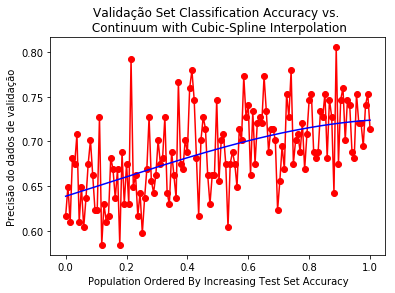

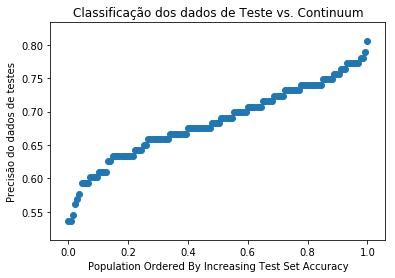

In [14]:
tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
ynew = interpolate.splev(percentileList, tck)

e = plt.figure(1)
plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
plt.plot(percentileList, ynew, color='b')
plt.title('Validação Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Precisão do dados de validação')
e.show()

g = plt.figure(2)
plt.scatter(percentileList, testAccuracyList)
plt.title('Classificação dos dados de Teste vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Precisão do dados de testes')
g.show()